<a href="https://colab.research.google.com/github/jomericer/rhabdo_death_krt/blob/main/rhabdo_death_krt_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Init**

In [39]:
import pandas as pd
import numpy as np
import os
import matplotlib.pylab as plt

from sklearn.ensemble import RandomForestClassifier
from matplotlib.pylab import rcParams
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_score, recall_score, brier_score_loss, fbeta_score, precision_recall_curve, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate

%matplotlib inline

# load datasets
df_e = pd.read_csv(f'{root}/datasets/df_e.csv')
df_m = pd.read_csv(f'{root}/datasets/df_m.csv')
df_c = pd.read_csv(f'{root}/datasets/df_c.csv')
print('datasets loaded')

# setup inputs and output
invars = ['age','aniongap','bicarbonate','urea','calcium','sodium','chloride','creatinine','potassium','phosphate','ck',
       'hematocrit','sex_F','ethnicity_white','wbc','platelet']
outvar = 'composite_rrt_death' # either composite_rrt_death or aki_7d_cr

# determine amount of class imbalance
db=['mimic','eicu','combined']
avg=[0]*3
for i, df_ in enumerate([df_m, df_e, df_c]):
  len_=df_.shape[0]
  pos=sum(df_[outvar])
  neg=len_-pos
  avg[i]=neg/pos
  print(f'{db[i]}: len={len_}, pos(1)={pos}, neg(0)={neg} => {pos/(len_)*100:.2f}%, scale_pos_weight={neg/pos:.2f}')
print(f'avg scale_pos_weight={np.mean(avg):.2f}')

# generate train and test datasets
split = 0.3
RAND = 15
folds = 3
m1_df = df_e # train/test dataset
val = df_m # validate dataset
comb_df_imp = df_c # combined
X = m1_df.loc[:,invars].copy()
y = m1_df[outvar].copy().fillna(0)
X__test = val.loc[:,invars].copy()
y__test = val[outvar].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, stratify=y, random_state=RAND)
print(f"\ntotal features: {len(invars)};  output = {outvar} -> total 1's = {y.sum()} ({y.sum()/len(y)*100:.1f}%)\ntrain size = {1-split}, test size = {split}")
print("Train and Test datasets created")


datasets loaded
mimic: len=764, pos(1)=75, neg(0)=689 => 9.82%, scale_pos_weight=9.19
eicu: len=753, pos(1)=131, neg(0)=622 => 17.40%, scale_pos_weight=4.75
combined: len=1517, pos(1)=206, neg(0)=1311 => 13.58%, scale_pos_weight=6.36
avg scale_pos_weight=6.77

total features: 16;  output = composite_rrt_death -> total 1's = 131 (17.4%)
train size = 0.7, test size = 0.3
Train and Test datasets created


**ML model**

Performing CV with 3-folds...
CV using Stratified Kfold strategy:
 Train accuracy: 0.8577, (0.0233) 
  Test accuracy: 0.7666, (0.0117) 
 Train AUC: 0.9490, (0.0065) 
  Test AUC: 0.7721, (0.0567) 
 Train logloss: -0.3569, (0.0161) 
  Test logloss: -0.4676, (0.0230) 

train
                | Pred=0     | Pred=1    
No KRT/death    |        357 |         78
KRT/death       |         17 |         75

Characteristics
  sens: 0.815217
  spec: 0.820690
   ppv: 0.490196
   npv: 0.954545
   LR+: 4.546405
   LR-: 0.225155
 F1 Score: 0.6122448979591837
 F0.5 Score 0.5326704545454545
 F2 Score 0.7197696737044145
 Brier: 0.1247519536206838
 BSS (50% prob): 0.5009921855172648

test
                | Pred=0     | Pred=1    
No KRT/death    |        159 |         28
KRT/death       |         12 |         27

Characteristics
  sens: 0.692308
  spec: 0.850267
   ppv: 0.490909
   npv: 0.929825
   LR+: 4.623626
   LR-: 0.361877
 F1 Score: 0.5744680851063829
 F0.5 Score 0.5212355212355213
 F2 Score 0.63981

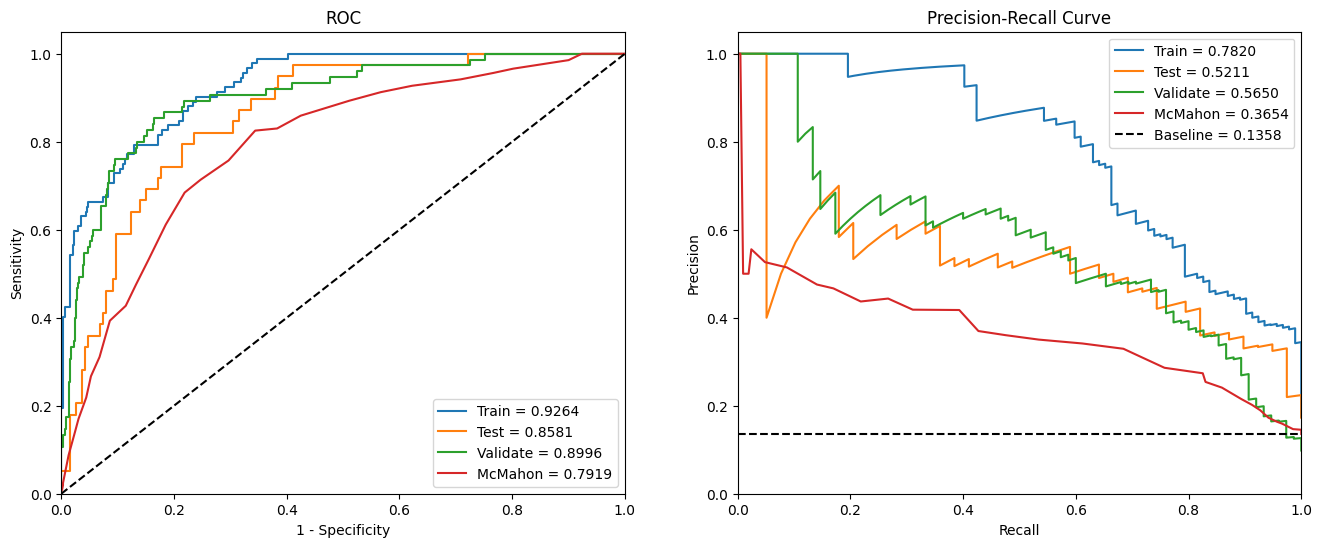

In [40]:
rfc = RandomForestClassifier(
    n_estimators=60,
    criterion='entropy',
    max_depth=4,
    min_samples_split=5,
    class_weight="balanced_subsample",
    ccp_alpha=0.016634211826061396,
    random_state=998,
    max_samples=None,
    verbose=0)

print(f"Performing CV with {folds}-folds...")
cv_scores = cross_validate(rfc, X_train, y_train,
                           scoring=['accuracy','roc_auc','neg_log_loss'],
                           cv=StratifiedKFold(folds), return_train_score=True, verbose=0)
print(f"CV using Stratified Kfold strategy:\n \
Train accuracy: {np.mean(cv_scores['train_accuracy']):.4f}, ({np.std(cv_scores['train_accuracy']):.4f}) \n \
 Test accuracy: {np.mean(cv_scores['test_accuracy']):.4f}, ({np.std(cv_scores['test_accuracy']):.4f}) \n \
Train AUC: {np.mean(cv_scores['train_roc_auc']):.4f}, ({np.std(cv_scores['train_roc_auc']):.4f}) \n \
 Test AUC: {np.mean(cv_scores['test_roc_auc']):.4f}, ({np.std(cv_scores['test_roc_auc']):.4f}) \n \
Train logloss: {np.mean(cv_scores['train_neg_log_loss']):.4f}, ({np.std(cv_scores['train_neg_log_loss']):.4f}) \n \
 Test logloss: {np.mean(cv_scores['test_neg_log_loss']):.4f}, ({np.std(cv_scores['test_neg_log_loss']):.4f}) ")

# fit model
rfc.fit(X_train, y_train)
train_pred = rfc.predict(X_train)
train_prob = rfc.predict_proba(X_train)[:,1]
test_pred = rfc.predict(X_test)
test_prob = rfc.predict_proba(X_test)[:,1]
val_pred = rfc.predict(X__test)
val_prob = rfc.predict_proba(X__test)[:,1]

# Metrics
fpr_m, tpr_m, thr = roc_curve(comb_df_imp[outvar], comb_df_imp['mcmahon'])
optimal_idx = np.argmax(tpr_m - fpr_m)
AUCm  = auc(fpr_m, tpr_m)
mcmahon_pred = [1 if y >= thr[optimal_idx] else 0 for y in comb_df_imp['mcmahon']]
mcmahon_prob = [0.5]*len(comb_df_imp)
y_all=comb_df_imp[outvar]

for x, y, z, xyz in zip([y_train, y_test, y__test, y_all], [train_pred, test_pred, val_pred, mcmahon_pred], ['train','test','validate','mcmahon'], [train_prob, test_prob, val_prob, mcmahon_prob]):
  cm = confusion_matrix(x, y) # get values to calculate sens/spec & LR's
  print(f"\n{z}")
  print(f"{'':15} | {'Pred=0':10} | {'Pred=1':10}")
  print(f"{'No KRT/death':15} | {cm[0,0]:10} | {cm[0,1]:10}")
  print(f"{'KRT/death':15} | {cm[1,0]:10} | {cm[1,1]:10}")
  sn = cm[1,1]/(cm[1,1]+cm[1,0]) # Sens = TP / (TP + FN)
  sp = cm[0,0]/(cm[0,0]+cm[0,1]) # Spec = TN / (FP + TN)
  ppv = cm[1,1]/(cm[1,1]+cm[0,1]) # PPV = TP / (TP + FP)
  npv = cm[0,0]/(cm[0,0]+cm[1,0]) # NPV = TN / (FN + TN)
  pl = sn/(1-sp)
  nl = (1-sn)/sp
  print("\nCharacteristics")
  print("  sens: %f" % sn)
  print("  spec: %f" % sp)
  print("   ppv: %f" % ppv)
  print("   npv: %f" % npv)
  print("   LR+: %f" % pl)
  print("   LR-: %f" % nl)
  print(f" F1 Score: {fbeta_score(x, y, beta=1)}")
  print(f" F0.5 Score {fbeta_score(x, y, beta=0.5)}")
  print(f" F2 Score {fbeta_score(x, y, beta=2)}")
  print(f" Brier: {brier_score_loss(x, xyz)}")
  print(f" BSS (50% prob): {1-brier_score_loss(x, xyz)/0.25}")

# ROC
fpr, tpr, _ = roc_curve(y_train, train_prob)
AUC_ = auc(fpr, tpr)
fprt, tprt, _ = roc_curve(y_test, test_prob)
AUCt = auc(fprt, tprt)
fprv, tprv, _ = roc_curve(y__test, val_prob)
AUCv = auc(fprv, tprv)
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.plot(fpr, tpr, label='Train = %0.4f' % AUC_)
plt.plot(fprt, tprt, label='Test = %0.4f' % AUCt)
plt.plot(fprv, tprv, label='Validate = %0.4f' % AUCv)
plt.plot(fpr_m, tpr_m, label='McMahon = %0.4f' % AUCm)
plt.plot([0, 1], [0, 1], 'k--') # 0.5 line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC')
plt.legend(loc="lower right")

# precision recall
pr0, re0, _ = precision_recall_curve(y_train, train_prob)
pr1, re1, _ = precision_recall_curve(y_test, test_prob)
pr2, re2, _ = precision_recall_curve(y__test, val_prob)
prm, rem, _ = precision_recall_curve(y_all, comb_df_imp['mcmahon'])
auc0 = auc(re0, pr0)
auc1 = auc(re1, pr1)
auc2 = auc(re2, pr2)
aucm = auc(rem, prm)
no_skill = len(y_all[y_all==1]) / len(y_all) # class imbalance ~14% in combined dataset
plt.subplot(122)
plt.plot(re0, pr0, label='Train = %0.4f' % auc0)
plt.plot(re1, pr1, label='Test = %0.4f' % auc1)
plt.plot(re2, pr2, label='Validate = %0.4f' % auc2)
plt.plot(rem, prm, label='McMahon = %0.4f' % aucm)
plt.plot([0, 1], [no_skill, no_skill], 'k--', label="Baseline = %0.4f" % no_skill) # '0.5 line' fixed for class imbalance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()